In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [13]:
def reassign_outliers(pdf, columnName, verbose=False):
  """
  There is an extrem outlier in the data which is probably a mistake. 
  I will reassign the value to the mean of the column.
  """

  outlier_loc = np.where(pdf[columnName] < np.mean(pdf[columnName])-3*np.std(pdf[columnName]))
  (pdf[columnName].values)[outlier_loc] = np.mean(pdf[columnName]) #this causes data leakage, not ideal
  
  if verbose:
    print(f"Reassigned {len(outlier_loc)} values.")
  return pdf[columnName]

In [14]:
path = 'data/Monthly-hourly-load-values_2006-2015.xlsx'
#read file which has the header in the 4th row
df = pd.read_excel(path, header=3) 

#let's sum over the columns  0,1,..23 to get the daily sum
df["dailySumMWh"] = df[np.arange(0,24)].sum(axis=1)
df["dailySumMWh"] = (1-df["Coverage ratio"]/100+1)*df["dailySumMWh"]

#let's combine the column year month and day to a single column
df['date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])

#let's keep only dailySumMWh and date and country
df = df[['Country','date','dailySumMWh']]

#let's rename the column country to country
df = df.rename(columns={'Country': 'country'})


In [15]:
path = 'data/MHLV_data-2015-2019.xlsx'
for sheet in ['2015-2017', '2018-2019']:
    #let's read both sheets of the excel file
    df2 = pd.read_excel(path, sheet_name=sheet, header=0)  #2015-2017 is in fact 01.01.2016-31.12.2017.

    #let's exact duplicates in the hourly data, ex. dez 2018 for Italy
    df2 = df2.drop_duplicates(subset=['Value_ScaleTo100','CountryCode', 'DateShort','TimeFrom', 'TimeTo'], keep='first')
    
    #let's only keep Value_ScaleTo100, CountryCode, DateShort
    df2 = df2[['Value_ScaleTo100', 'CountryCode', 'DateShort']]

    #let's convert DateShort Column to datetime format
    df2['DateShort'] = pd.to_datetime(df2['DateShort']) 

    #let's rename the column Value_Scaled to Value
    df2 = df2.rename(columns={'Value_ScaleTo100': 'dailySumMWh', 'CountryCode':'country', 'DateShort':'date'})

    #Let's grouby DateShort and CountryCode and then sum
    df2 = df2.groupby(['date','country']).sum()

    #let's make the group index back to normal columns
    df2 = df2.reset_index()

    #let's concat the dataframes
    df = pd.concat([df, df2], axis=0)


In [16]:
#let's reset the index after concatenating
df = df.reset_index(drop=True)

#let's get rid of the douplicates, they come from concatenating the dataframes
df = df.drop_duplicates(subset=['date','country'], keep='first')

#let's fill zeros with mean per country
for country in df['country'].unique():  
    country_df = df[df['country'] == country]  
    df.loc[country_df.index,'dailySumMWh']= (country_df['dailySumMWh']).transform(lambda x: x.replace(0, np.mean(x))).values

#Let's drop the data that looks bad
bad_data = ['CY', 'ME', 'GR', 'CS', 'TR','AL','CH']
df = df[~df['country'].isin(bad_data)]

In [17]:
for country in df['country'].unique(): 
    country_df = df[df['country'] == country]
    df.loc[country_df.index,'dailySumMWh']= reassign_outliers(country_df, 'dailySumMWh')

In [18]:
df

,country,date,dailySumMWh
0,AT,2006-01-01,145451.00
1,AT,2006-01-02,176630.00
2,AT,2006-01-03,179083.00
3,AT,2006-01-04,179265.00
4,AT,2006-01-05,178663.00
...,...,...,...
162934,ES,2019-10-31,639571.00
162935,HR,2019-10-31,47878.00
162936,HU,2019-10-31,121774.11
162937,MK,2019-10-31,19602.00


#### Add the data from SwissGrid

In [19]:
sdf = pd.read_csv("data/swissGridExport.csv", names=["date", "dailySumkWh"])                 
sdf['date'] = pd.to_datetime(sdf['date'])

#drop the timezone information
sdf['date'] = sdf['date'].dt.tz_localize(None)

#sort the dataframe by timestamp
sdf = sdf.sort_values(by=['date'])

#remove first row
sdf = sdf.iloc[1:]
sdf = sdf[sdf['date'] < '2020-01-01']

sdf["dailySumMWh"] = sdf["dailySumkWh"] / 1e3
sdf = sdf.drop(columns=['dailySumkWh'])
sdf["country"] = "CH"

#reindex
sdf = sdf.reset_index(drop=True)

df = pd.concat([df, sdf], axis=0)

In [20]:
df

,country,date,dailySumMWh
0,AT,2006-01-01,145451.000000
1,AT,2006-01-02,176630.000000
2,AT,2006-01-03,179083.000000
3,AT,2006-01-04,179265.000000
4,AT,2006-01-05,178663.000000
...,...,...,...
4012,CH,2019-12-27,168491.898529
4013,CH,2019-12-28,166862.526883
4014,CH,2019-12-29,169923.053818
4015,CH,2019-12-30,180612.376897


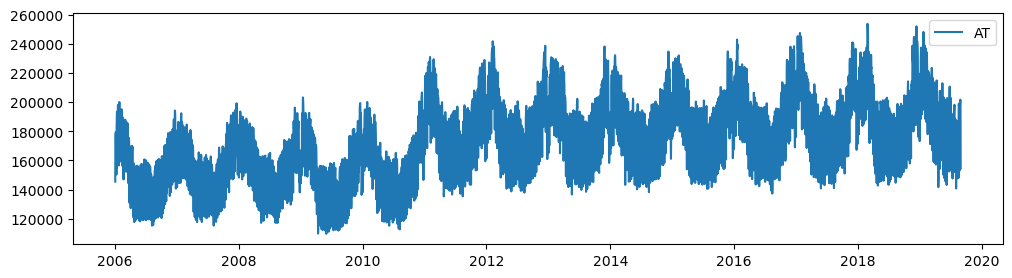

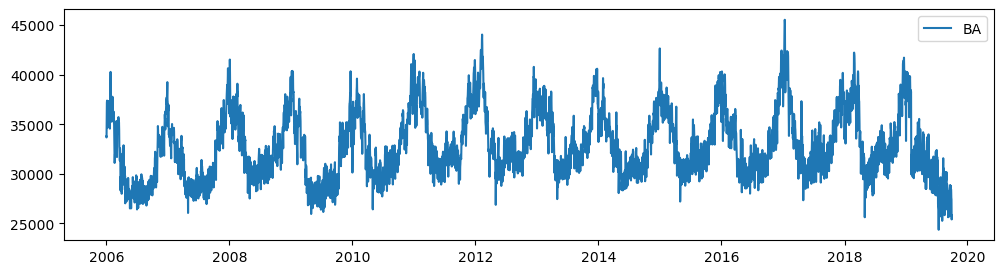

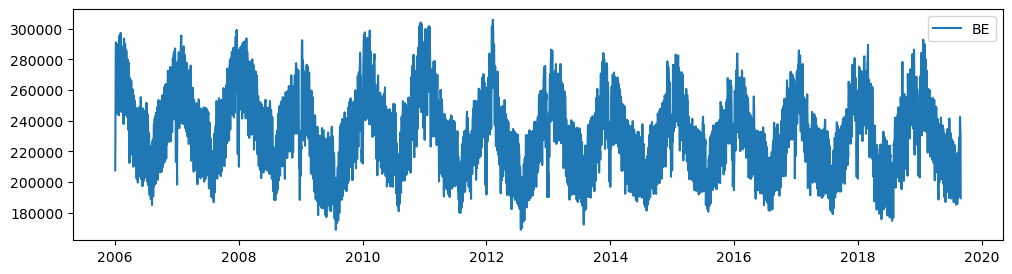

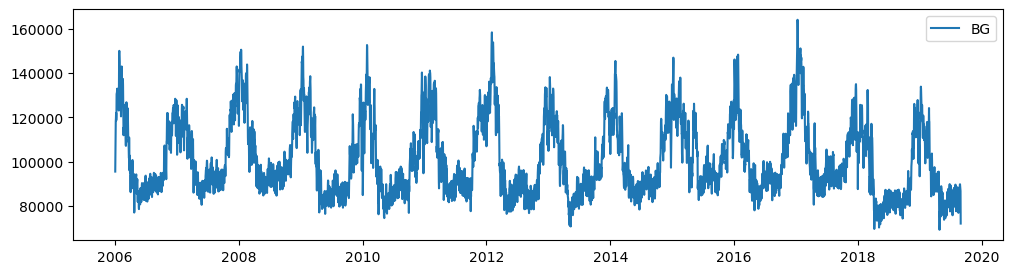

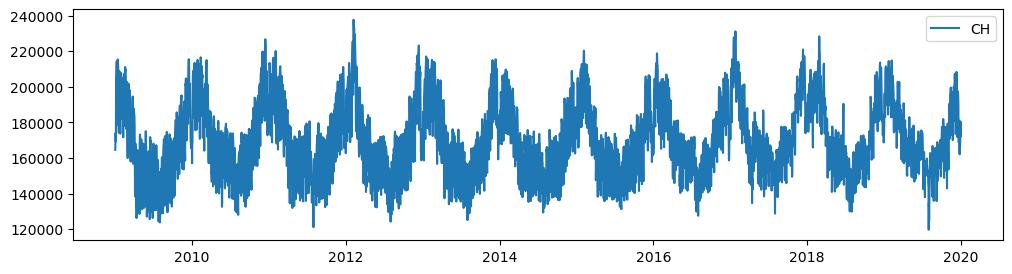

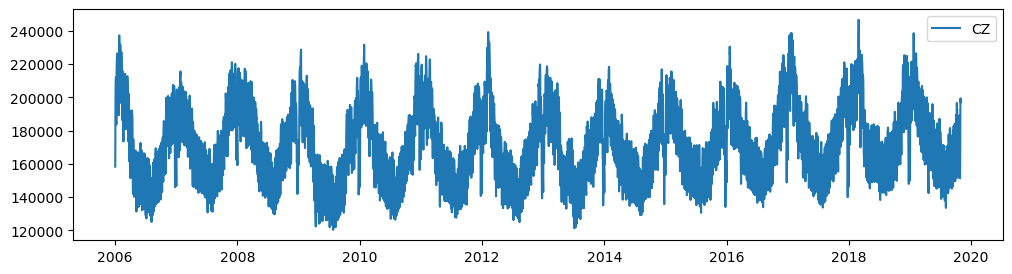

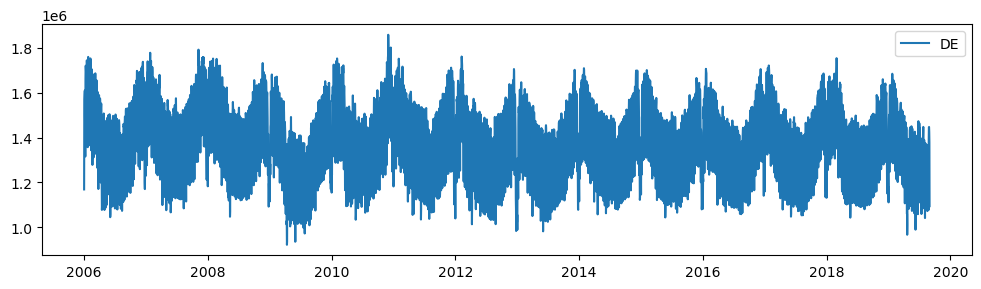

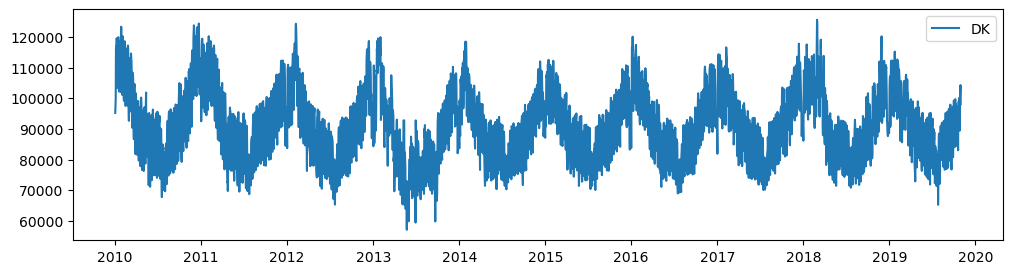

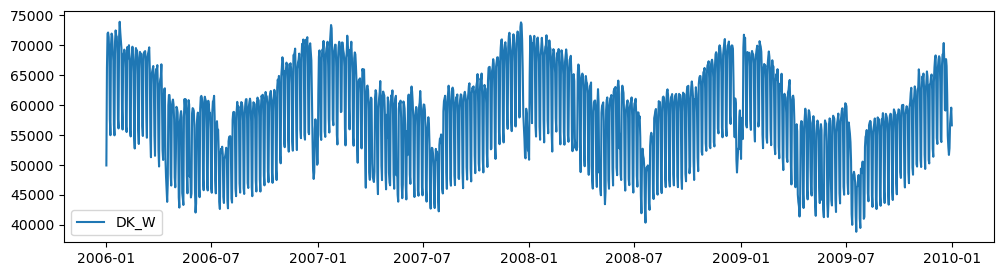

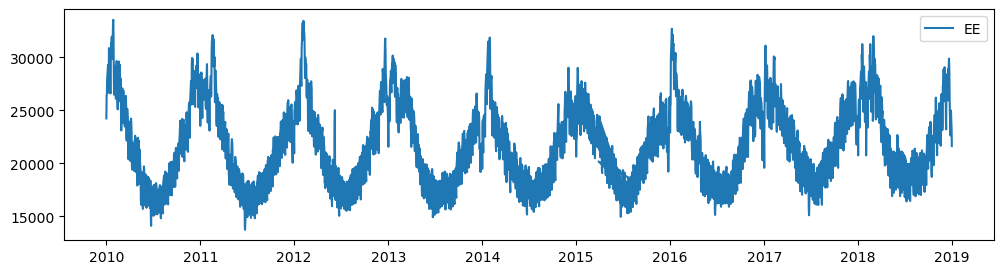

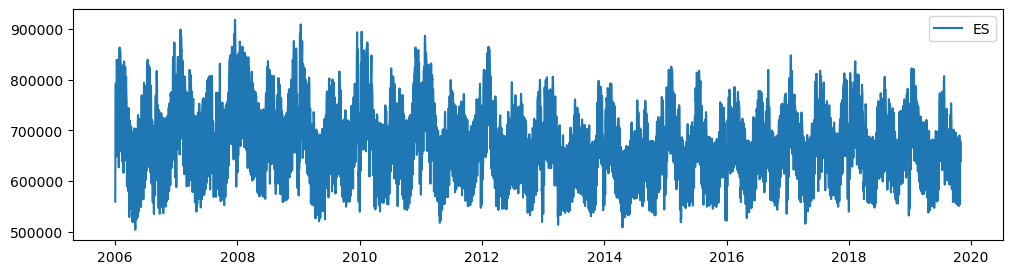

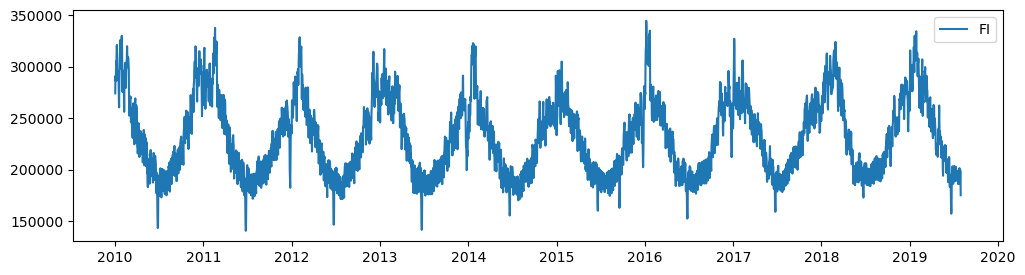

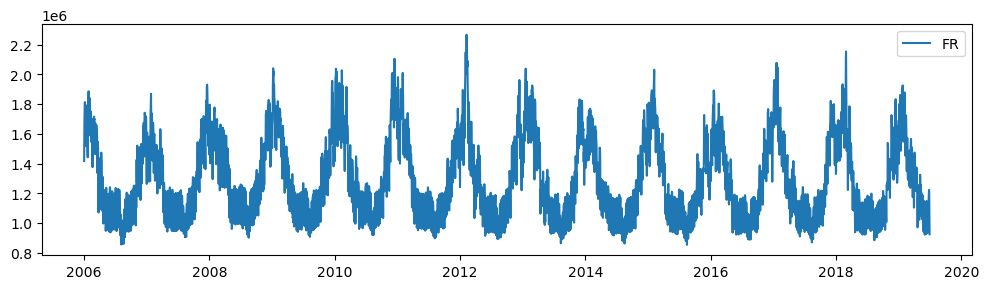

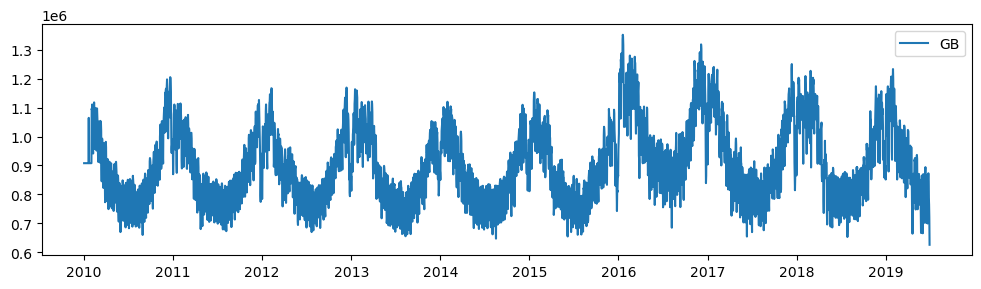

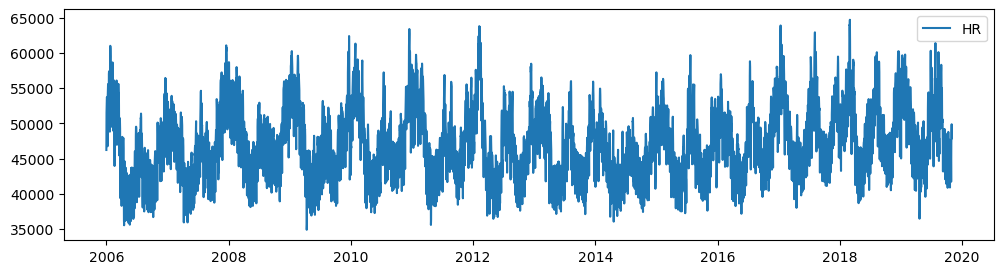

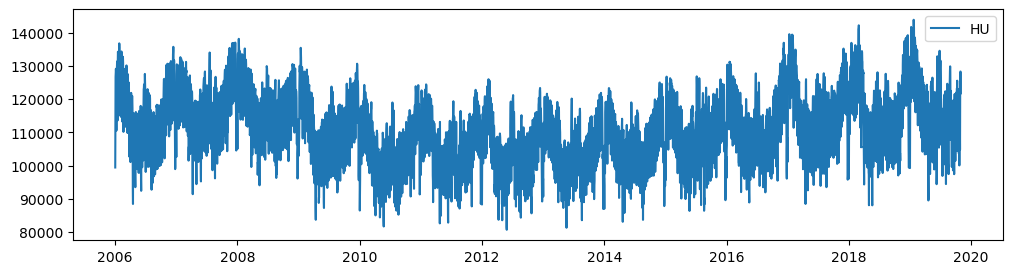

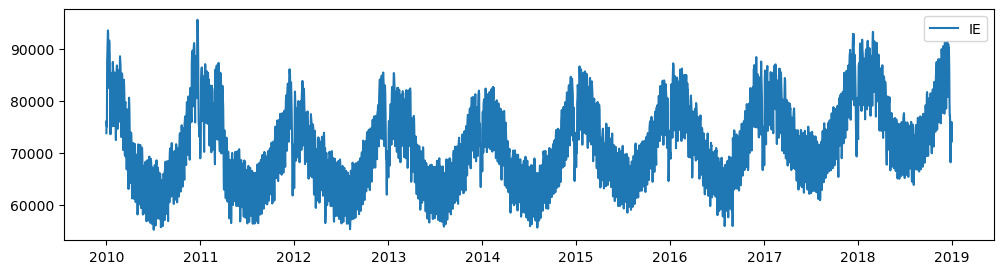

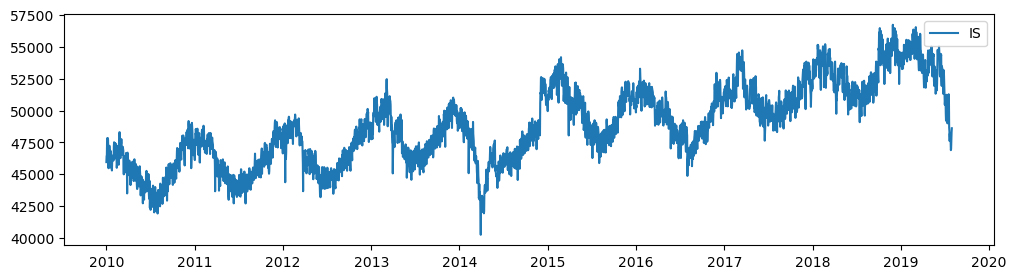

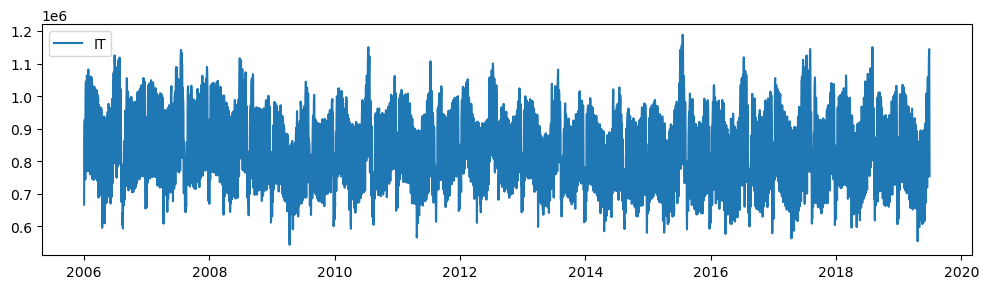

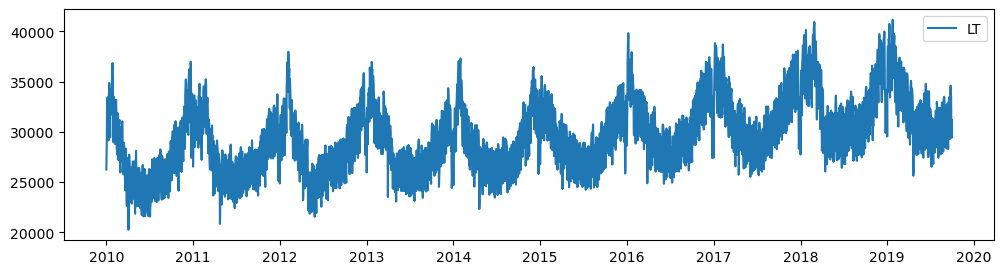

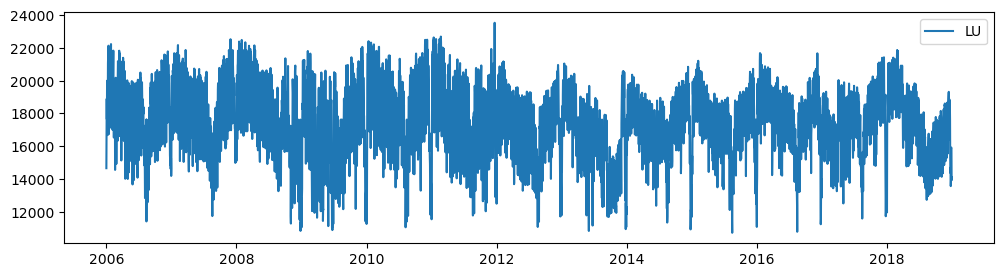

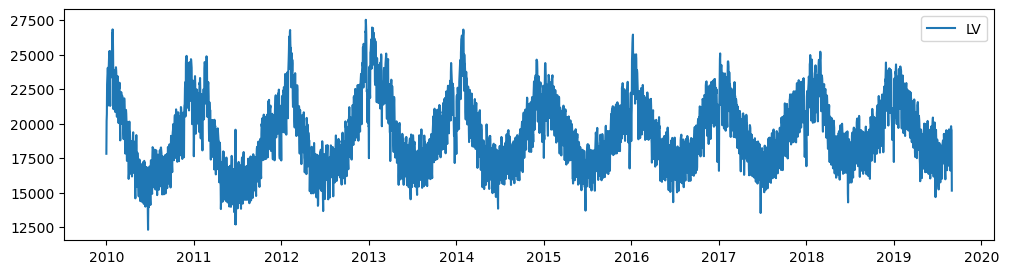

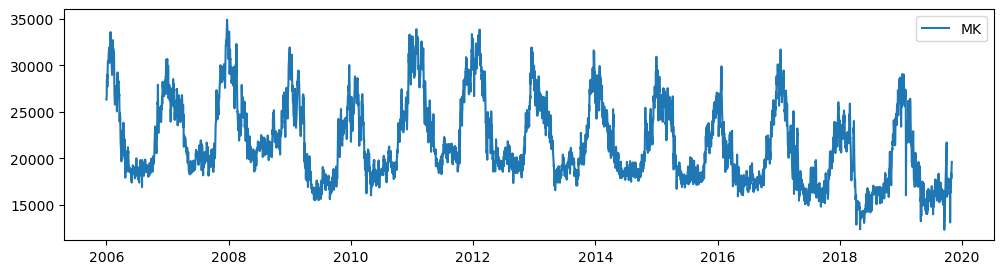

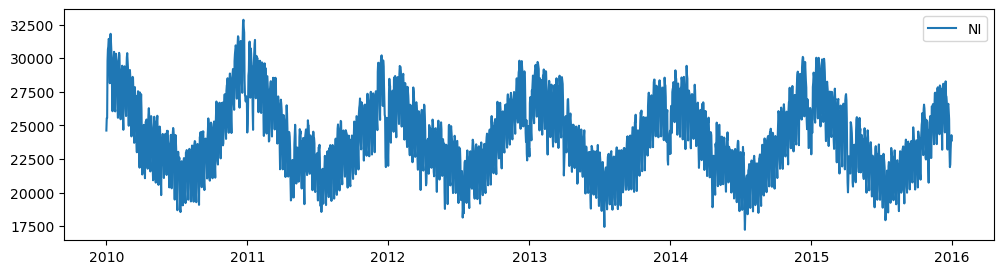

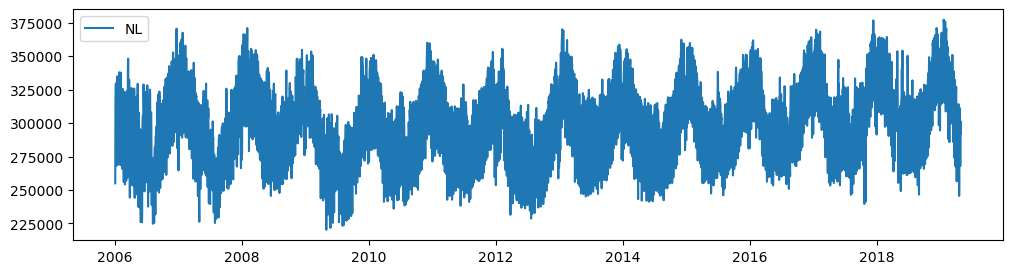

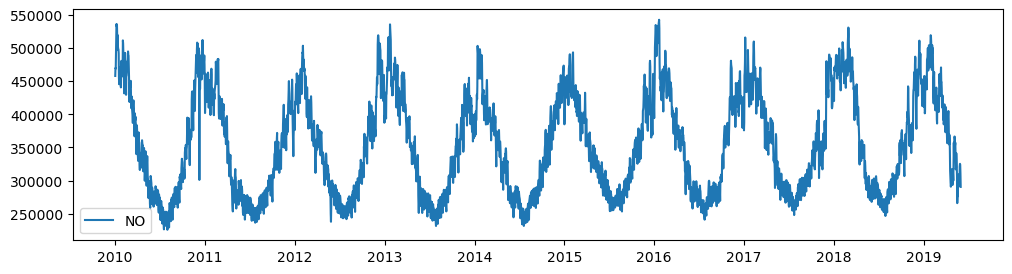

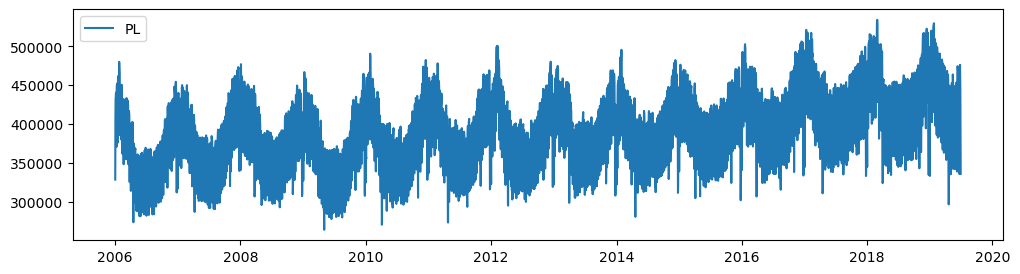

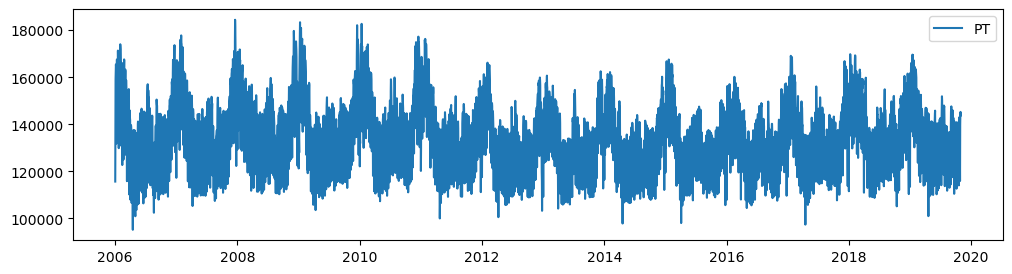

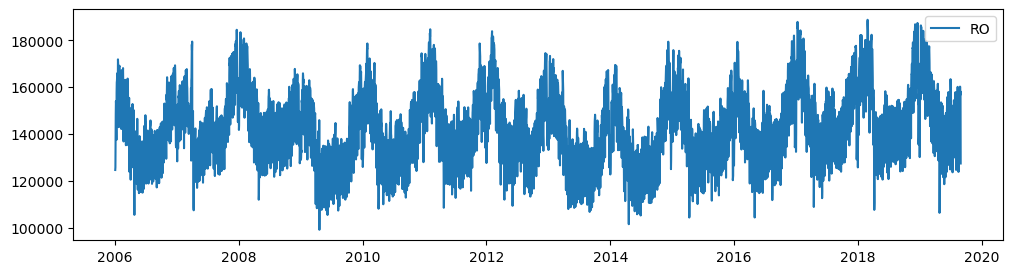

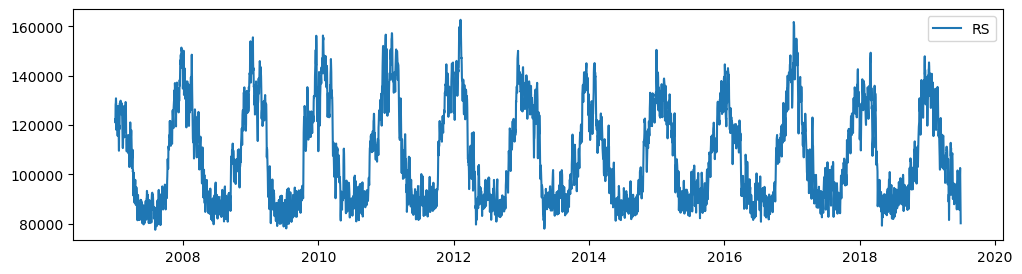

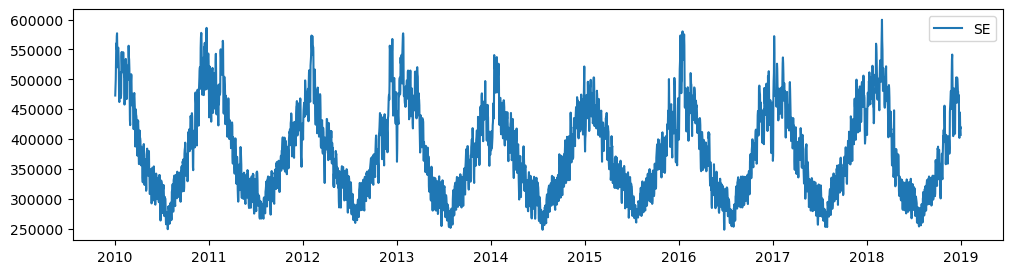

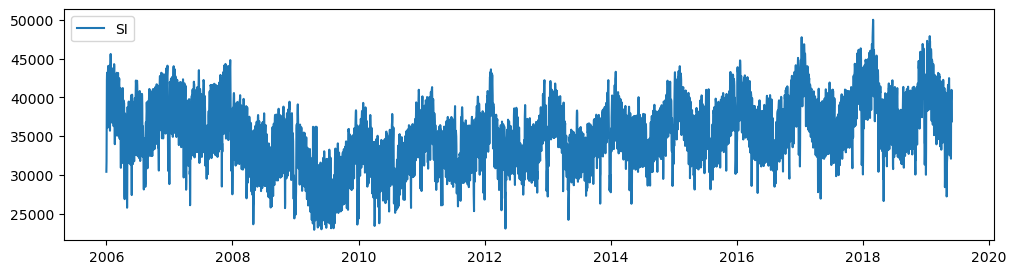

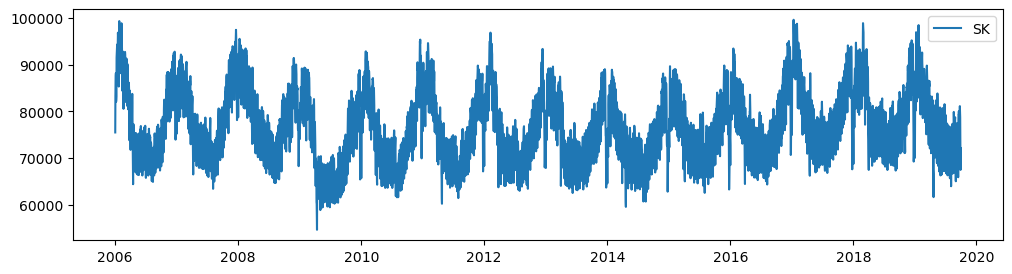

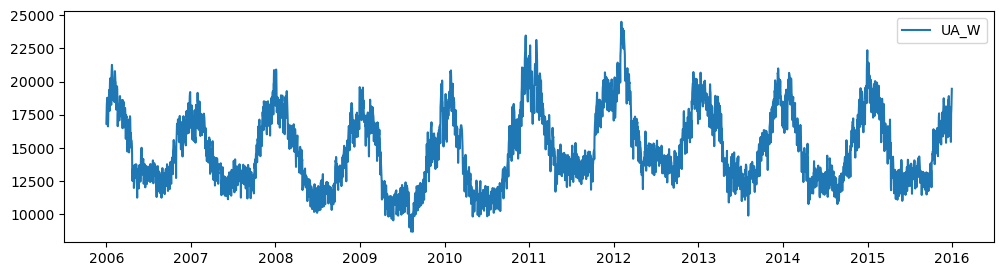

In [21]:
# Create a plot for each group
for name, group in df.groupby('country'):
    plt.figure(figsize=(12,3))
    plt.plot(group['date'],group['dailySumMWh'], label=f'{name}')
    plt.legend()
    plt.show()

In [22]:
#save this dataframe as a csv file
df.to_csv('data/cleaned_daily.csv', index=False)

#### Data After Covid